In [11]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches
import statsmodels.api as sm
import numpy as np
from itertools import product
import subprocess
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor, XGBClassifier

import shap

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
with open("../../config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt
import utils
import emb

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]
R_PATH = LOCAL_CONFIG["R_PATH"]

RUN_R_SCRIPTS = False
OVERWRITE = False


In [12]:
# Some basic data cleaning / wranging

posts = dt.get_posts()
posts['week'] = dt.as_week(posts['created_at'])

mask = (posts['invoiceActionState'] != 'FAILED') & \
    (~posts['bio']) & (~posts['freebie']) & (~posts['saloon']) & \
    (posts['subName'].notnull()) & (posts['subName'] != '') & \
    (~posts['subName'].isin(['jobs', 'ama'])) & \
    (posts['title'] != 'deleted by author') & \
    (globals.data_end - posts['created_at'] >= pd.Timedelta(hours=48))

posts = posts.loc[mask].reset_index(drop=True)
posts['text'] = posts['text'].fillna('')
posts['num_img_or_links'] = posts['text'].apply(dt.count_image_or_links)
posts['num_words'] = posts['text'].apply(lambda x: len(x.split()))
posts['is_link_post'] = (posts['url'].notnull()) & (posts['url'] != '')
posts['link_only'] = posts['is_link_post'] & (posts['text'].str.strip() == '')

print(len(posts))

/Users/ekung/projects/sn-research/src/notebooks/../python/data_tools.py:89: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time


191334


In [13]:
# Table showing some determinants of post quality

posts['has_img_or_links'] = posts['num_img_or_links'] > 0
posts['no_words'] = posts['num_words'] == 0
posts['lo_words'] = (posts['num_words'] > 0) & (posts['num_words'] <= 50)
posts['hi_words'] = posts['num_words'] > 50

tbl = "\\renewcommand{\\arraystretch}{1.2} \n"
tbl += "\\begin{tabular}{llccc} \n"
tbl += "\\toprule \n"
tbl += "  &   &   \\multicolumn{3}{c}{Number of words} \\\\ \n"
tbl += "  &   &   None       & 1-50       & >50        \\\\ \\hline  \n"
for link_post in [True, False]:
    if link_post:
        tbl += "\\multirow{6}{*}{Is link post} & "
    else:
        tbl += "\\multirow{6}{*}{Not link post} & "
    for img_or_link in [False, True]:
        if img_or_link:
            tbl += " & \\multirow{3}{*}{Has images or links} "
        else:
            tbl += "\\multirow{3}{*}{No images or links} "
        for word_cat in ['no_words', 'lo_words', 'hi_words']:
            if (word_cat == 'no_words') & (img_or_link == True):
                tbl += " & "
                continue
            mask = (posts['is_link_post'] == link_post) & (posts['has_img_or_links'] == img_or_link) & (posts[word_cat])
            zaps48 = posts.loc[mask, 'sats48'].mean()
            tbl += f"& $\\bar{{z}} = {zaps48:,.0f}$"
        tbl += " \\\\ \n"
        tbl += " & "
        for word_cat in ['no_words', 'lo_words', 'hi_words']:
            if (word_cat == 'no_words') & (img_or_link == True):
                tbl += " & "
                continue
            mask = (posts['is_link_post'] == link_post) & (posts['has_img_or_links'] == img_or_link) & (posts[word_cat])
            comments48 = posts.loc[mask, 'comments48'].mean()
            tbl += f"& $\\bar{{c}} = {comments48:,.1f}$"
        tbl += " \\\\ \n"
        tbl += " & "
        for word_cat in ['no_words', 'lo_words', 'hi_words']:
            if (word_cat == 'no_words') & (img_or_link == True):
                tbl += " & "
                continue
            mask = (posts['is_link_post'] == link_post) & (posts['has_img_or_links'] == img_or_link) & (posts[word_cat])
            n_posts = len(posts.loc[mask])
            tbl += f"& $N = {n_posts:,.0f}$"
        if img_or_link == False:
            tbl += " \\\\ \\cline{2-5} \n "
        else:
            tbl += " \\\\ \\hline \n"
tbl += "\\end{tabular} \n"
tbl += "\\renewcommand{\\arraystretch}{1} \n"
print(tbl)

\renewcommand{\arraystretch}{1.2} 
\begin{tabular}{llccc} 
\toprule 
  &   &   \multicolumn{3}{c}{Number of words} \\ 
  &   &   None       & 1-50       & >50        \\ \hline  
\multirow{6}{*}{Is link post} & \multirow{3}{*}{No images or links} & $\bar{z} = 166$& $\bar{z} = 214$& $\bar{z} = 250$ \\ 
 & & $\bar{c} = 1.2$& $\bar{c} = 2.4$& $\bar{c} = 2.7$ \\ 
 & & $N = 91,721$& $N = 10,392$& $N = 10,486$ \\ \cline{2-5} 
  & \multirow{3}{*}{Has images or links}  & & $\bar{z} = 202$& $\bar{z} = 513$ \\ 
 &  & & $\bar{c} = 1.3$& $\bar{c} = 3.5$ \\ 
 &  & & $N = 6,308$& $N = 5,899$ \\ \hline 
\multirow{6}{*}{Not link post} & \multirow{3}{*}{No images or links} & $\bar{z} = 309$& $\bar{z} = 371$& $\bar{z} = 706$ \\ 
 & & $\bar{c} = 7.0$& $\bar{c} = 8.6$& $\bar{c} = 10.1$ \\ 
 & & $N = 1,725$& $N = 8,917$& $N = 15,251$ \\ \cline{2-5} 
  & \multirow{3}{*}{Has images or links}  & & $\bar{z} = 280$& $\bar{z} = 1,303$ \\ 
 &  & & $\bar{c} = 3.7$& $\bar{c} = 8.0$ \\ 
 &  & & $N = 17,103$& $N = 23,

hi_quality
False    146652
True      44682
Name: count, dtype: int64


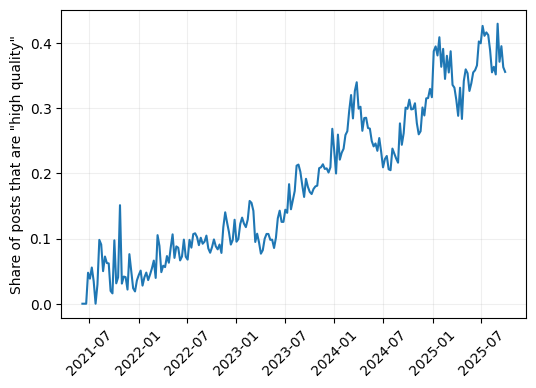

In [21]:
# High quality posts

posts['hi_quality'] = (posts['hi_words'] & ~posts['is_link_post']) | (posts['is_link_post'] & posts['hi_words'] & posts['has_img_or_links'])

print(posts['hi_quality'].value_counts())

plot_df = posts.groupby('week').agg(
    total_posts = ('itemId', 'count'),
    hi_quality_posts = ('hi_quality', 'sum')
).reset_index()

plt.figure(figsize = (6,4))
plt.plot(plot_df['week'], plot_df['hi_quality_posts'] / plot_df['total_posts'])
plt.xticks(rotation=45)
plt.grid(alpha=0.2)
plt.ylabel('Share of posts that are "high quality"')
plt.show()


In [8]:
posts['week']

KeyError: 'week'

In [4]:
title_embeddings = {}
text_embeddings = {}

for idx, row in posts.iterrows():
    itemId = row['itemId']

    title_emb = np.array(emb.get_embedding_robust(row['title']))
    title_emb = title_emb / np.linalg.norm(title_emb)
    title_embeddings[itemId] = title_emb
    
    text_emb = np.array(emb.get_embedding_robust(row['text']))
    text_emb = text_emb / np.linalg.norm(text_emb)
    text_embeddings[itemId] = text_emb


In [6]:
posts.loc[posts['num_words']>0, 'num_words'].describe()

count    97888.000000
mean       153.326598
std        314.701477
min          1.000000
25%         21.000000
50%         63.000000
75%        167.000000
max      15868.000000
Name: num_words, dtype: float64

In [4]:
posts = posts.sort_values(by=['userId', 'created_at'], ascending=[True, True]).reset_index(drop=True)

for idx, row in posts.iterrows():
    created_at = row['created_at']
    userId = row['userId']
    itemId = row['itemId']
    sub_df = posts[
        (posts['userId']==userId) & (posts['created_at']>created_at)
    ].sort_values(by='created_at', ascending=True).head(5).reset_index(drop=True)

    my_embedding = text_embeddings[itemId]

    tot_dist = 0
    if len(sub_df)==5:
        for jdx, sub_row in sub_df.iterrows():
            sub_itemId = sub_row['itemId']
            sub_embedding = text_embeddings[sub_itemId]
            cos_dist = 1 - np.dot(my_embedding, sub_embedding) / (np.linalg.norm(my_embedding) * np.linalg.norm(sub_embedding))
            tot_dist += cos_dist
        avg_dist = tot_dist / 5
        posts.at[idx, 'future_text_dist'] = avg_dist


In [8]:
posts.to_parquet(
    os.path.join(DATA_PATH, "v4v_analysis_data.parquet")
)

In [9]:
posts

,itemId,created_at,updated_at,title,text,url,userId,parentId,path,pinId,...,root_is_saloon,n_uploads,hasImageOrLink,sats48,zappers48,downsats48,downzappers48,cost_modifier,comments48,future_text_dist
0,224722,2023-08-14 12:01:32.116000+00:00,2023-08-14 12:11:33.730,Why do many bitcoiners still trust fiat software?,We have all bought into using free and open so...,None,9,NaN,224722,NaN,...,None,0,True,846.0,15.0,0.0,0.0,0,49.0,0.116494
1,225751,2023-08-15 13:21:49.073000+00:00,2023-08-15 13:31:50.847,Why do many bitcoiners still trust fiat software?,We have all bought into using free and open so...,None,9,NaN,225751,NaN,...,None,0,True,1949.0,11.0,0.0,0.0,0,20.0,0.145863
2,226502,2023-08-16 13:11:16.003000+00:00,2023-08-16 13:21:17.642,How can I use open source software if I don't ...,There are a lot of great tools available for m...,None,9,NaN,226502,NaN,...,None,0,True,1473.0,15.0,1.0,1.0,0,43.0,0.000077
3,227213,2023-08-17 11:50:04.118000+00:00,2023-08-17 12:00:05.507,How can I use open source software if I don't ...,There are a lot of great tools available for m...,None,9,NaN,227213,NaN,...,None,0,True,0.0,0.0,0.0,0.0,0,21.0,0.000051
4,228034,2023-08-18 13:36:36.802000+00:00,2023-08-18 13:46:38.197,How can I use open source software if I don't ...,There are a lot of great tools available for m...,None,9,NaN,228034,NaN,...,None,0,True,0.0,0.0,1.0,1.0,0,7.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191329,1240929,2025-09-28 19:37:15.109000+00:00,2025-09-28 19:48:32.869,EU Chat Control Worsens,"Germany, Belgium, Latvia, and Italy UNDECIDED....",http://fightchatcontrol.eu,30704,NaN,1240929,NaN,...,None,0,False,1339.0,10.0,0.0,0.0,0,26.0,NaN
191330,1245197,2025-10-02 01:04:22.737000+00:00,2025-10-02 01:14:43.416,ArtofProof Launch: A Protocol for Verifiable A...,\n\n![](https://m.stacker.news/110427)\n\n\nA ...,None,30726,NaN,1245197,NaN,...,None,1,True,1.0,1.0,0.0,0.0,0,0.0,NaN
191331,1245418,2025-10-02 06:31:51.636000+00:00,2025-10-03 18:10:44.556,How high can bitcoin go in October?,,https://cointelegraph.com/news/how-high-can-bi...,30729,NaN,1245418,NaN,...,None,0,False,0.0,0.0,0.0,0.0,0,0.0,NaN
191332,1247726,2025-10-03 18:03:38.606000+00:00,2025-10-03 18:19:25.497,A New Bitcoin All-Time High Could Come As Earl...,,https://cryptonews.net/31734271/?utm_source=Cr...,30729,NaN,1247726,NaN,...,None,0,False,0.0,0.0,0.0,0.0,0,0.0,NaN
